In [18]:
import numpy as np
import pandas as pd
import yaml
from IPython.display import display
import importlib
import copy
import awkward as ak
import seaborn as sns
import matplotlib.pyplot as plt

import study_lib

In [2]:
base_config_yaml = """
candidates: 5
voters: 555
considerations:
- Likability:
    mean: 0.25
- Irrational:
    sigma: 1.0
    camps: 7
    individualism_deg: 30
- Issues:
    - sigma: 1.0
      halfcsep: 1.5
      halfvsep: 2.0
    - sigma: 0.5
      halfcsep: 1.0
    - sigma: 0.5
      halfcsep: 2.0
methods:
- Plurality:
    strat: Honest
- Plurality:
    strat: Strategic
- Range:
    nranks: 10
    strat: Honest
- Range:
    nranks: 10
    strat: Strategic
    strategic_stretch_factor: 1.5
- Range:
    nranks: 2
    strat: Honest
- Range:
    nranks: 2
    strat: Strategic
    strategic_stretch_factor: 4.0
- InstantRunoff: {}
- STAR:
    strat: Honest
- STAR:
    strat: Strategic
    strategic_stretch_factor: 1.5
- RP:
    strat: Honest
"""
config = yaml.safe_load(base_config_yaml)

In [3]:
importlib.reload(study_lib)
do_run = study_lib.do_run 
run_experiment = study_lib.run_experiment
cs = study_lib.config_series

In [5]:
df = run_experiment(cs(config, 'candidates', [2, 3, 4, 5, 6]), trials=10000)
df

,candidates,pl_h_mR,pl_s_mR,range_10_h_mR,range_10_s_mR,aprv_h_mR,aprv_s_mR,IRV_h_mR,star_6_h_mR,star_6_s_mR,rp_h_mR
0,2,0.092200,0.092200,0.092200,0.092200,0.092200,0.092200,0.092200,0.092200,0.092200,0.092200
1,3,0.263755,0.064070,0.030990,0.029666,0.033997,0.037035,0.065145,0.035182,0.036580,0.035973
2,4,0.273363,0.072655,0.021260,0.018558,0.023538,0.025712,0.059472,0.022813,0.025035,0.024740
3,5,0.286056,0.092452,0.016297,0.013801,0.021564,0.019175,0.055892,0.016595,0.019593,0.020274
4,6,0.289517,0.103552,0.012164,0.010268,0.019648,0.015615,0.051656,0.013397,0.015524,0.016266


In [6]:
config_like_only = copy.deepcopy(config)
config_like_only['candidates'] = 4
config_like_only['considerations'] = yaml.safe_load(
'''
- Likability:
    mean: 1.0
'''
)
result = do_run(config_like_only, 5)
display(result['cand_regret'][0])
display(result['cov_matrix'][0])

<Array [0.739, 1.22, 2.04, 0] type='4 * ?float64'>

<Array [[0], [0, 0], [...], [0, 0, 0, 0]] type='4 * option[var * ?float64]'>

With likability as the only consideration, all voter sets of utilities are identical to each other. Variances and covariances are zero.

In [10]:
def get_corr_coeffs(result, trial_no):
    covm = result['cov_matrix'][trial_no]
    ncand = len(covm)
    cc = np.eye(ncand, dtype=np.float64)
    sigmas = []
    for i in range(ncand):
        sigmas.append(np.sqrt(covm[(i, i)]))
    # print(sigmas)
    for ix in range(ncand):
        for iy in range(ix):
            cc[(ix, iy)] = covm[(ix, iy)] / sigmas[ix] / sigmas[iy]
    return cc

In [13]:
display(get_corr_coeffs(result, 0))

/tmp/ipykernel_600875/3163430169.py:11: RuntimeWarning: invalid value encountered in scalar divide
  cc[(ix, iy)] = covm[(ix, iy)] / sigmas[ix] / sigmas[iy]


array([[ 1.,  0.,  0.,  0.],
       [nan,  1.,  0.,  0.],
       [nan, nan,  1.,  0.],
       [nan, nan, nan,  1.]])

In [14]:
config_irr = copy.deepcopy(config)
config_irr['candidates'] = 4
config_irr['voters'] = 100001
config_irr['considerations'] = yaml.safe_load(
'''
- Irrational:
    sigma: 1.0
    camps: 2
    individualism_deg: 90
'''
)
result = do_run(config_irr, 5)
display(get_corr_coeffs(result, 0))
display(get_corr_coeffs(result, 1))


array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.00268738,  1.        ,  0.        ,  0.        ],
       [ 0.00172234, -0.00139973,  1.        ,  0.        ],
       [-0.00171959,  0.00580155, -0.00432785,  1.        ]])

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.03732485e-03,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 7.94856619e-03,  8.72417434e-04,  1.00000000e+00,
         0.00000000e+00],
       [ 5.62530531e-06,  2.96202197e-04, -1.73552066e-03,
         1.00000000e+00]])

Good. Correlation coefficients are very small, because irrational voters (all independent) have utilities that are uncorrelated with those of other voters.

### This ended up being fodder for a unit test of the Irrational consideration

In [200]:
utilities = np.random.uniform(0., np.sqrt(12.), 50)
utilities = np.reshape(utilities, newshape=(5, 10))
utilities

array([[0.3090016 , 2.09904798, 0.82317008, 3.13087807, 1.61064933,
        2.01657254, 2.91759999, 1.55519431, 2.89235991, 2.97551052],
       [2.24721985, 2.65914812, 1.86329343, 2.21673783, 0.84797068,
        0.56396652, 0.44596168, 3.40639598, 0.65299382, 1.77379581],
       [0.58539738, 1.22377722, 3.06071522, 1.3184892 , 0.48842566,
        0.79741721, 2.61924207, 3.07438678, 1.22978133, 3.12792367],
       [2.85872826, 0.52028883, 1.38963001, 0.35922687, 0.16900879,
        1.34662276, 0.17156912, 1.73254542, 1.48895542, 1.27941031],
       [0.78623712, 0.66519608, 1.30919134, 2.73176796, 1.99823116,
        3.12736477, 3.38542127, 1.83569564, 3.25960743, 1.54455224]])

In [201]:
np.set_printoptions(threshold=100000)
print(str(utilities.transpose()))

[[0.3090016  2.24721985 0.58539738 2.85872826 0.78623712]
 [2.09904798 2.65914812 1.22377722 0.52028883 0.66519608]
 [0.82317008 1.86329343 3.06071522 1.38963001 1.30919134]
 [3.13087807 2.21673783 1.3184892  0.35922687 2.73176796]
 [1.61064933 0.84797068 0.48842566 0.16900879 1.99823116]
 [2.01657254 0.56396652 0.79741721 1.34662276 3.12736477]
 [2.91759999 0.44596168 2.61924207 0.17156912 3.38542127]
 [1.55519431 3.40639598 3.07438678 1.73254542 1.83569564]
 [2.89235991 0.65299382 1.22978133 1.48895542 3.25960743]
 [2.97551052 1.77379581 3.12792367 1.27941031 1.54455224]]


In [202]:
np.cov(utilities)

array([[ 0.94020538, -0.32073684,  0.16108757, -0.49611513,  0.62033183],
       [-0.32073684,  1.01169877,  0.31368278,  0.27153381, -0.70086438],
       [ 0.16108757,  0.31368278,  1.19057637, -0.00328159, -0.05275154],
       [-0.49611513,  0.27153381, -0.00328159,  0.71388613, -0.31396175],
       [ 0.62033183, -0.70086438, -0.05275154, -0.31396175,  1.02640331]])

In [220]:
utilities = np.random.uniform(0., np.sqrt(12.), 5000)
utilities = np.reshape(utilities, newshape=(5, 1000))
np.cov(utilities)

array([[ 0.99333244, -0.00444264,  0.01690256,  0.0234099 , -0.03744667],
       [-0.00444264,  1.01777285, -0.02395978, -0.02019903, -0.06810528],
       [ 0.01690256, -0.02395978,  0.99728841, -0.08037311, -0.03790731],
       [ 0.0234099 , -0.02019903, -0.08037311,  1.00854158,  0.02726133],
       [-0.03744667, -0.06810528, -0.03790731,  0.02726133,  0.99367376]])

In [11]:
config_issue = copy.deepcopy(config)
config_issue['candidates'] = 4
config_issue['voters'] = 100001
config_issue['considerations'] = yaml.safe_load(
'''
- Issues:
    - halfcsep: 1.0
      halfvsep: 1.0
      sigma: 1.0
'''
)
result = do_run(config_issue, 5)
display(get_corr_coeffs(result, 0))
display(get_corr_coeffs(result, 1))
# display(get_corr_coeffs(result, 2))
# display(get_corr_coeffs(result, 3))

array([[1.        , 0.        , 0.        , 0.        ],
       [0.82319955, 1.        , 0.        , 0.        ],
       [0.35638636, 0.78743431, 1.        , 0.        ],
       [0.9370035 , 0.64582691, 0.13624312, 1.        ]])

array([[1.        , 0.        , 0.        , 0.        ],
       [0.99373726, 1.        , 0.        , 0.        ],
       [0.81509974, 0.87070626, 1.        , 0.        ],
       [0.87723509, 0.8218506 , 0.467876  , 1.        ]])

When there's a political axis, voters are much more significantly correlated with each other.

In [16]:
config_new = copy.deepcopy(config)
config_new['candidates'] = 6
config_new['considerations'] = yaml.safe_load(
'''
- Irrational:
    sigma: 1.0
    camps: 11
    individualism_deg: 20
'''
)
result = do_run(config_new, 5000)
np.mean(result['num_smith'])

np.float64(1.4408)

In [17]:
display(result.fields)

['ideal_cand',
 'cand_regret',
 'Irrational',
 'cov_matrix',
 'num_smith',
 'in_smith',
 'methods']

In [19]:
study_lib.run_experiment(
    cs(config, 'considerations.1.Irrational.sigma', [0., 0.5, 2.0, 4.0, 40.0]),
    2000,
    sm=True,
)

,Irrational,avg_nsmith,pl_h_mR,pl_h_insm,pl_s_mR,pl_s_insm,range_10_h_mR,range_10_h_insm,range_10_s_mR,range_10_s_insm,...,aprv_s_mR,aprv_s_insm,IRV_h_mR,IRV_h_insm,star_6_h_mR,star_6_h_insm,star_6_s_mR,star_6_s_insm,rp_h_mR,rp_h_insm
0,0.0,1.0965,0.424064,53.8,0.225163,72.05,0.038813,83.15,0.033466,87.90,...,0.060382,94.90,0.168867,75.80,0.052018,93.05,0.064300,97.75,0.071441,100.00
1,0.5,1.0375,0.387119,55.4,0.162038,77.70,0.024679,89.35,0.020236,93.05,...,0.028792,98.35,0.102386,84.05,0.024211,96.95,0.028388,99.10,0.029857,100.00
2,2.0,1.0545,0.127995,76.7,0.046447,92.90,0.011018,91.00,0.010087,94.75,...,0.020732,99.15,0.035061,95.05,0.016646,97.00,0.021499,99.65,0.020737,99.95
3,4.0,1.0985,0.138646,76.2,0.071293,92.55,0.016990,90.75,0.018584,94.80,...,0.039319,99.10,0.061531,94.55,0.033079,97.70,0.035984,99.60,0.036682,100.00
4,40.0,1.1400,0.176669,76.2,0.101690,91.65,0.018515,88.55,0.028991,93.75,...,0.060658,98.40,0.083979,94.50,0.045113,97.15,0.055601,99.70,0.050192,100.00


In [14]:
config_new = copy.deepcopy(config)
config_new['candidates'] = 6
config_new['considerations'] = yaml.safe_load(
'''
- Issues:
  - sigma: 1.0
    halfcsep: 1.5
    halfvsep: 2.0
  - sigma: 1.0
    halfcsep: 0.0
    halfvsep: 0.0
'''
)
study_lib.run_experiment(
    cs(config_new, 'considerations.0.Issues.1.sigma', [0., 1., 2., 4.0]),
    5000,
    sm=True
)

,1,avg_nsmith,pl_h_mR,pl_h_insm,pl_s_mR,pl_s_insm,range_10_h_mR,range_10_h_insm,range_10_s_mR,range_10_s_insm,...,aprv_s_mR,aprv_s_insm,IRV_h_mR,IRV_h_insm,star_6_h_mR,star_6_h_insm,star_6_s_mR,star_6_s_insm,rp_h_mR,rp_h_insm
0,0.0,1.0000,1.052219,9.56,0.809012,15.88,0.071049,61.76,0.036228,74.40,...,0.017130,90.70,0.744674,12.60,0.044468,73.26,0.019828,87.36,0.005786,100.0
1,1.0,1.0152,0.829766,16.84,0.480676,29.38,0.048733,73.22,0.033903,82.62,...,0.031710,93.52,0.438564,26.80,0.029856,85.88,0.028929,94.86,0.028875,100.0
2,2.0,1.0182,0.454381,34.20,0.232263,50.58,0.024549,81.38,0.012496,89.64,...,0.013267,95.10,0.190063,52.74,0.010947,89.72,0.009665,97.20,0.009241,100.0
3,4.0,1.0052,0.400536,39.20,0.164843,60.00,0.027344,79.68,0.009675,89.68,...,0.012653,92.42,0.145253,59.40,0.009887,88.96,0.005549,96.66,0.002794,100.0


In [34]:
config_new = copy.deepcopy(config)
# config_new['candidates'] = 6
config_new['considerations'] = yaml.safe_load(
'''
- Issues:
  - sigma: 1.0
    halfcsep: 1.5
    halfvsep: 1.5
'''
)
study_lib.run_experiment(
    cs(config_new, 'candidates', [2, 3, 4, 5, 6, 10]),
    5000,
    sm=True
)

,candidates,avg_nsmith,pl_h_mR,pl_h_insm,pl_s_mR,pl_s_insm,range_10_h_mR,range_10_h_insm,range_10_s_mR,range_10_s_insm,...,aprv_s_mR,aprv_s_insm,IRV_h_mR,IRV_h_insm,star_6_h_mR,star_6_h_insm,star_6_s_mR,star_6_s_insm,rp_h_mR,rp_h_insm
0,2,1.0,0.030800,100.00,0.030800,100.00,0.030800,100.00,0.030800,100.00,...,0.030800,100.00,0.030800,100.00,0.030800,100.00,0.030800,100.00,0.030800,100.0
1,3,1.0,0.455597,59.98,0.160500,78.54,0.068346,79.50,0.034893,87.86,...,0.009013,100.00,0.160617,78.56,0.010529,96.78,0.009013,100.00,0.009013,100.0
2,4,1.0,0.553329,42.34,0.253669,64.52,0.060190,76.16,0.029717,85.44,...,0.014101,95.12,0.256093,59.84,0.016523,91.36,0.004900,98.16,0.004324,100.0
3,5,1.0,0.654372,29.16,0.310595,54.50,0.058084,72.78,0.029194,83.90,...,0.015745,92.78,0.313425,45.14,0.020709,86.36,0.006432,95.92,0.002428,100.0
4,6,1.0,0.714005,22.12,0.349851,47.80,0.048985,71.32,0.022467,82.64,...,0.015945,91.38,0.371302,34.04,0.023474,81.48,0.007746,93.08,0.001402,100.0
5,10,1.0,0.858374,11.00,0.434301,31.30,0.032225,64.44,0.014712,79.46,...,0.013650,86.66,0.445708,13.00,0.024886,68.78,0.010918,85.44,0.000713,100.0


In [4]:
config_new = copy.deepcopy(config)
config_new['candidates'] = 10
config_new['considerations'] = [{
    'Issues': [
        dict(sigma=1.0, halfcsep=1.5, halfvsep=1.5),
    ]
}]
rslt_10c = do_run(config_new, 10000)

In [5]:
iss = ak.flatten(rslt_10c.issues, axis=2)
iss[:2]

<Array [[2, -2.19, ..., -0.676, 1.27], ...] type='2 * option[var * ?float64]'>

In [12]:
pl_h_winner_iss = iss[np.arange(len(iss)), rslt_10c.methods.pl_h.winner]
aprv_h_winner_iss = iss[np.arange(len(iss)), rslt_10c.methods.aprv_h.winner]
#all_iss = ak.ravel(rslt_10c.issues)
all_iss = rslt_10c.issues[:,0,0]

In [7]:
rslt_10c.issues

<Array [[[2], [-2.19], ..., [1.27]], ...] type='10000 * option[10 * option[...'>

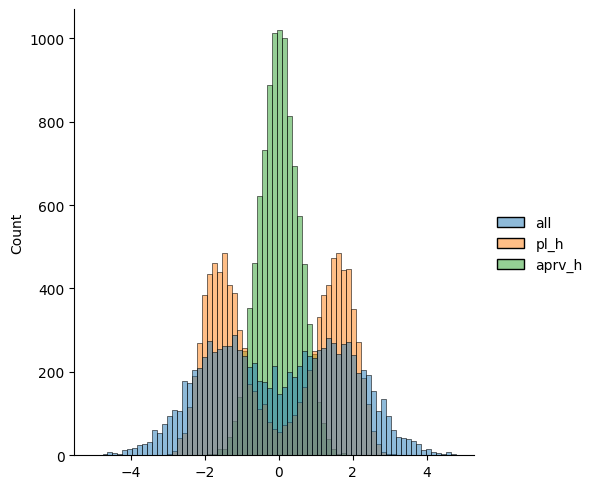

In [13]:
sns.displot({'all':all_iss, 'pl_h':pl_h_winner_iss, 'aprv_h':aprv_h_winner_iss})

In [11]:
rslt_10c.methods.fields

['pl_h',
 'pl_s',
 'range_10_h',
 'range_10_s',
 'aprv_h',
 'aprv_s',
 'IRV_h',
 'star_6_h',
 'star_6_s',
 'rp_h']

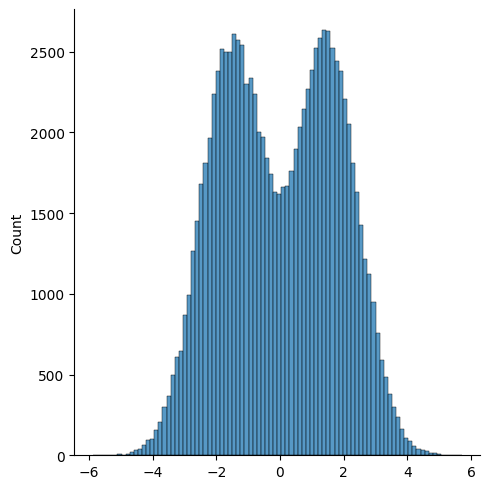

In [9]:
sns.displot(ak.ravel(rslt_10c.issues))

In [36]:
rp_h_winner_iss = iss[np.arange(len(iss)), rslt_10c.methods.rp_h.winner]
IRV_h_winner_iss = iss[np.arange(len(iss)), rslt_10c.methods.IRV_h.winner]

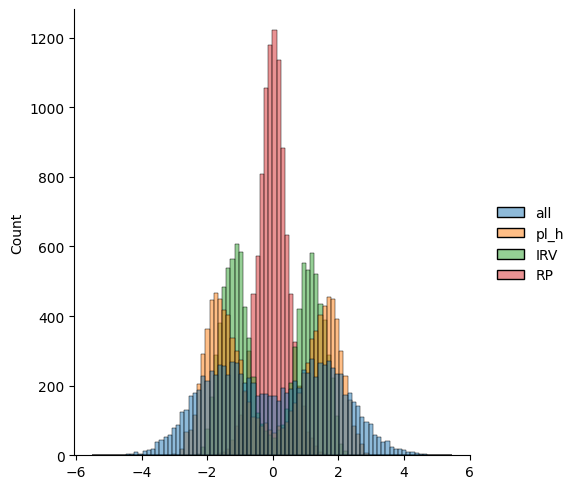

In [37]:
sns.displot({'all':all_iss, 'pl_h':pl_h_winner_iss, 'IRV':IRV_h_winner_iss, 'RP':rp_h_winner_iss})

In [41]:
config_new = copy.deepcopy(config)
config_new['candidates'] = 2
config_new['considerations'] = [{
    'Issues': [
        dict(sigma=1.0, halfcsep=1.5, halfvsep=1.5),
    ]
}]
rslt_2c = do_run(config_new, 100000)

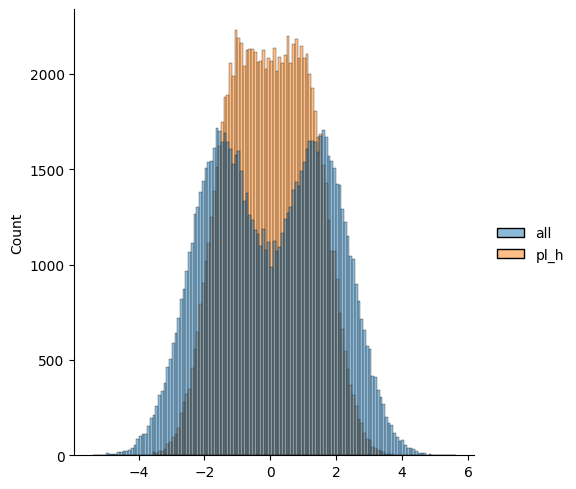

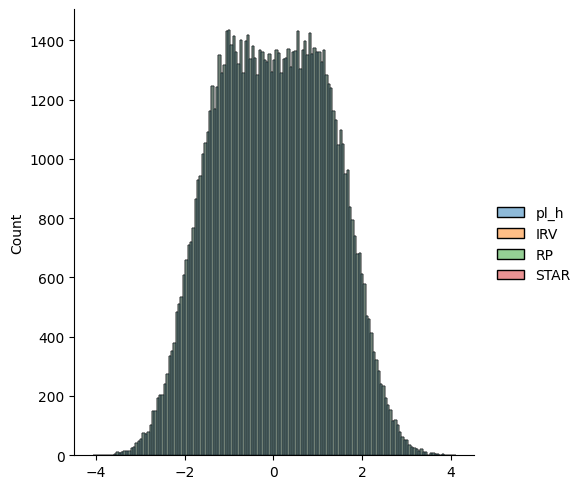

In [48]:
rslt = rslt_2c
iss = ak.flatten(rslt.issues, axis=2)
all_iss = rslt.issues[:,0,0]
pl_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.pl_h.winner]
rp_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.rp_h.winner]
IRV_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.IRV_h.winner]
rp_h_winner_star = iss[np.arange(len(iss)), rslt.methods.star_6_h.winner]
sns.displot({'all':all_iss, 'pl_h':pl_h_winner_iss})
sns.displot({'pl_h':pl_h_winner_iss, 'IRV':IRV_h_winner_iss, 'RP':rp_h_winner_iss, 'STAR':rp_h_winner_star})

In [7]:
config_new = copy.deepcopy(config)
config_new['candidates'] = 3
config_new['considerations'] = [{
    'Issues': [
        dict(sigma=1.0, halfcsep=1.5, halfvsep=1.5),
    ]
}]
rslt_3c = do_run(config_new, 100000)

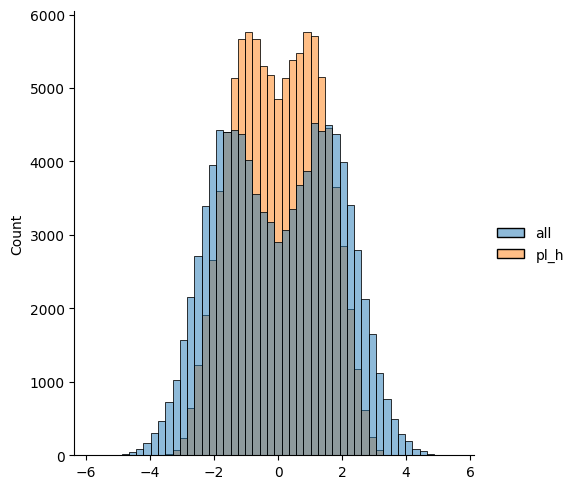

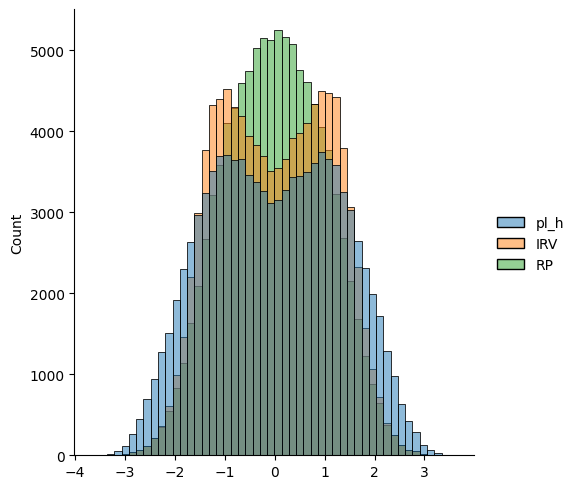

In [8]:
rslt = rslt_3c
iss = ak.flatten(rslt.issues, axis=2)
all_iss = rslt.issues[:,0,0]
pl_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.pl_h.winner]
rp_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.rp_h.winner]
IRV_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.IRV_h.winner]
rp_h_winner_star = iss[np.arange(len(iss)), rslt.methods.star_6_h.winner]
sns.displot({'all':all_iss, 'pl_h':pl_h_winner_iss}, bins=50)
sns.displot({'pl_h':pl_h_winner_iss, 'IRV':IRV_h_winner_iss, 'RP':rp_h_winner_iss}, bins=50)

In [18]:
config_new = copy.deepcopy(config)
config_new['candidates'] = 6
config_new['considerations'] = [{
    'Issues': [
        dict(sigma=1.0, halfcsep=1.0, halfvsep=1.0),
    ]
}]
rslt_5cg = do_run(config_new, 10000)

In [7]:
rslt = rslt_5cg
iss = ak.flatten(rslt.issues, axis=2)
all_iss = rslt.issues[:,0,0]
pl_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.pl_h.winner]
pl_s_winner_iss = iss[np.arange(len(iss)), rslt.methods.pl_s.winner]
rp_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.rp_h.winner]
IRV_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.IRV_h.winner]
rp_h_winner_star = iss[np.arange(len(iss)), rslt.methods.star_6_h.winner]
sns.displot({'all':all_iss, 'pl_h':pl_h_winner_iss, 'pl_s':pl_s_winner_iss}, bins=50)
sns.displot({'pl_s':pl_h_winner_iss, 'IRV':IRV_h_winner_iss, 'RP':rp_h_winner_iss}, bins=50)

NameError: name 'rslt_5cg' is not defined

In [15]:
config_new = copy.deepcopy(config)
config_new['candidates'] = 5
config_new['considerations'] = [{
    'Issues': [
        dict(sigma=1.0/np.sqrt(3.), halfcsep=0.0, uniform=True),
    ]
}]
rslt_5cu = do_run(config_new, 100000)

Text(0, 0.5, 'Simulated election winner (count)')

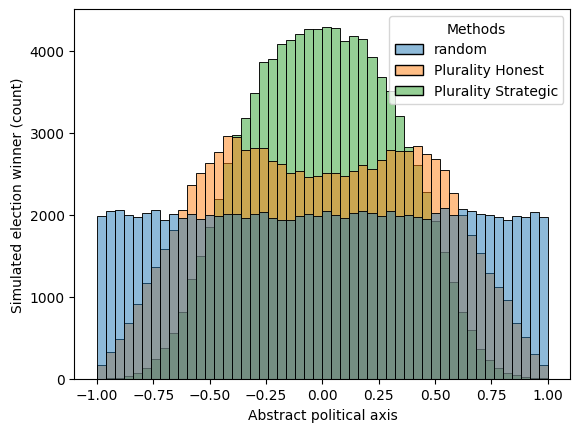

In [31]:
rslt = rslt_5cu
iss = ak.flatten(rslt.issues, axis=2)
all_iss = rslt.issues[:,0,0]
pl_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.pl_h.winner]
pl_s_winner_iss = iss[np.arange(len(iss)), rslt.methods.pl_s.winner]
rp_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.rp_h.winner]
IRV_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.IRV_h.winner]
star_h_winner_iss = iss[np.arange(len(iss)), rslt.methods.star_6_h.winner]
g = sns.histplot({'random':all_iss, 'Plurality Honest':pl_h_winner_iss, 'Plurality Strategic':pl_s_winner_iss}, bins=50)
# plt.legend(loc='center right', title='Method')
sns.move_legend(g, "upper right", title='Methods')
plt.xlabel('Abstract political axis')
plt.ylabel('Simulated election winner (count)')
# sns.histplot({'Plurality Honest':pl_h_winner_iss, 'Instant Runoff':IRV_h_winner_iss, 'RP':rp_h_winner_iss}, bins=50)
#sns.move_legend(plt.gca(), "upper right")

In [ ]:
sns.histplot({
    'Plurality Honest':pl_h_winner_iss,
    'Instant Runoff':IRV_h_winner_iss,
    'Rnkd Pairs':rp_h_winner_iss,
    'STAR':star_h_winner_iss
    }, bins=50)
sns.move_legend(g, "upper right", title='Methods')
plt.xlabel('Abstract political axis')
plt.ylabel('Simulated election winner (count)')